<a href="https://colab.research.google.com/github/JoseLuis96001/HyperparameterTunig_KerasTuner/blob/main/KerasTuner_TF_2_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Libraries

In [3]:
!pip install keras-tuner==1.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install tensorflow==2.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 51 kB/s 
     |████████████████████████████████| 459 kB 67.0 MB/s 
     |████████████████████████████████| 26.1 MB 1.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.0 MB/s 
     |████████████████████████████████| 2.9 MB 56.7 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
  

In [4]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

In [5]:
tf.__version__

'2.3.0'

In [6]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_test.shape

(10000, 28, 28)

In [9]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

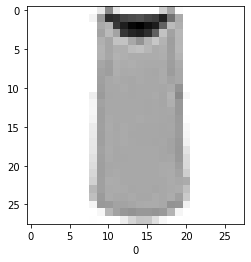

In [10]:
plt.imshow(x_train[2], cmap='binary')
plt.xlabel(y_train[2])
plt.show()

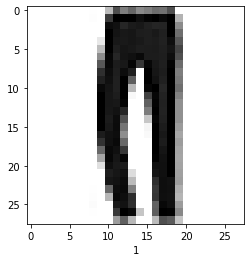

In [11]:
plt.imshow(x_test[2], cmap='binary')
plt.xlabel(y_test[2])
plt.show()

In [12]:
#from tensorflow.python.ops.gen_array_ops import inplace_update_eager_fallback
# def create_model(hp):
#   num_hidden_layers = 1 # this is a hyperparameter
#   num_units = 8 # another hyp...
#   dropout_rate = 0.1
#   learning_rate = 0.01

#   if hp:
#     num_hidden_layers = hp.Choice('num_hidden_layers', values = [1,2,3])
#     num_units = hp.Choice('num_units', values = [8,16,32])
#     dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
#     learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

#   model = tf.keras.models.Sequential() # used to groups a linear stack of layers into model.

#   model.add(tf.keras.layers.Flatten(input_shape = (28,28))) # flattens the multi-dimensional input tensors into a single dimension
#   model.add(tf.keras.layers.Lambda(lambda x: x/255.)) # normalization

#   for _ in range(0, num_hidden_layers):
#     model.add(tf.keras.layers.Dense(num_units, activation='relu')) # relu is an hy..
#     model.add(tf.keras.layers.Dropout(dropout_rate))

#   model.add(tf.keras.layers.Dense(10, activation='softmax'))

#   model.compile(
#       loss = "sparse_categorical_crossentropy",
#       optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
#       metrics = ['accuracy']
#   )

#   return model

Model Creation

In [13]:
def create_model(hp): # To use keras tuner, pass hyperparameter object to model

  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    num_hidden_layers = hp.Choice('num_hidden_layers', values=[1, 2, 3])
    num_units = hp.Choice('num_units', values=[8, 16, 32])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28))) # Unroll 28 x 28 image to 784-D vectors
  model.add(tf.keras.layers.Lambda(lambda x: x/255.)) # Preprocessing step: normalize input

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation='relu')) # Fully connected layer
    model.add(tf.keras.layers.Dropout(dropout_rate))
  
  model.add(tf.keras.layers.Dense(10, activation='softmax')) # Output layer, classification

  model.compile(
      loss='sparse_categorical_crossentropy', # Since labels are not one-hot encoded, categorical crossentropy is not used
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy']
  )
  return model

In [14]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


Keras Tuner

In [15]:
class CustomTuner(kerastuner.tuners.BayesianOptimization): # posible between Random search, BayesianOptimization, HyperBand
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [16]:
tuner = CustomTuner(
    create_model,
    objective = 'val_accuracy',
    max_trials = 20,
    directory = 'logs',
    project_name = 'fashin_mnist',
    overwrite =  True
)

In [17]:
tuner.search_space_summary()

In [18]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5, verbose = True
)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.2169 - accuracy: 0.5090 - val_loss: 0.6874 - val_accuracy: 0.7951
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0950 - accuracy: 0.5681 - val_loss: 0.6409 - val_accuracy: 0.7977
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0711 - accuracy: 0.5859 - val_loss: 0.6237 - val_accuracy: 0.7947
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0174 - accuracy: 0.6066 - val_loss: 0.5960 - val_accuracy: 0.8037
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0080 - accuracy: 0.6159 - val_loss: 0.6301 - val_accuracy: 0.7869


Epoch 1/5
625/625 [==============================] - 1s 2ms/step - loss: 2.0806 - accuracy: 0.1804 - val_loss: 1.6981 - val_accuracy: 0.3333
Epoch 2/5
625/625 [==============================] - 1s 2ms/step - loss: 1.9367 - accuracy: 0.2177 - val_loss: 1.5762 - val_accuracy: 0.3727
Epoch 3/5
625/625 [==============================] - 1s 2ms/step - loss: 1.7889 - accuracy: 0.2655 - val_loss: 1.5227 - val_accuracy: 0.3988
Epoch 4/5
625/625 [==============================] - 1s 2ms/step - loss: 1.7447 - accuracy: 0.2825 - val_loss: 1.5061 - val_accuracy: 0.4014
Epoch 5/5
625/625 [==============================] - 1s 2ms/step - loss: 1.7301 - accuracy: 0.2884 - val_loss: 1.4977 - val_accuracy: 0.3746


Epoch 1/5
938/938 [==============================] - 2s 2ms/step - loss: 0.7778 - accuracy: 0.7193 - val_loss: 0.5027 - val_accuracy: 0.8154
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.6138 - accuracy: 0.7779 - val_loss: 0.4732 - val_accuracy: 0.8315
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.5855 - accuracy: 0.7845 - val_loss: 0.4607 - val_accuracy: 0.8376
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.5723 - accuracy: 0.7908 - val_loss: 0.4558 - val_accuracy: 0.8349
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.5556 - accuracy: 0.7949 - val_loss: 0.4383 - val_accuracy: 0.8451


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.0290 - accuracy: 0.6500 - val_loss: 0.6780 - val_accuracy: 0.7813
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6800 - accuracy: 0.7708 - val_loss: 0.5681 - val_accuracy: 0.8071
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5914 - accuracy: 0.8001 - val_loss: 0.5197 - val_accuracy: 0.8214
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5444 - accuracy: 0.8151 - val_loss: 0.4920 - val_accuracy: 0.8297
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5104 - accuracy: 0.8244 - val_loss: 0.4698 - val_accuracy: 0.8342


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7469 - accuracy: 0.7224 - val_loss: 0.5614 - val_accuracy: 0.8066
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6321 - accuracy: 0.7718 - val_loss: 0.5370 - val_accuracy: 0.8096
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6132 - accuracy: 0.7798 - val_loss: 0.5446 - val_accuracy: 0.8157
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6023 - accuracy: 0.7835 - val_loss: 0.5335 - val_accuracy: 0.8096
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5942 - accuracy: 0.7873 - val_loss: 0.5154 - val_accuracy: 0.8208


Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 1.4080 - accuracy: 0.5559 - val_loss: 0.9071 - val_accuracy: 0.7338
Epoch 2/5
469/469 [==============================] - 1s 2ms/step - loss: 0.8519 - accuracy: 0.7253 - val_loss: 0.7091 - val_accuracy: 0.7745
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.7198 - accuracy: 0.7616 - val_loss: 0.6323 - val_accuracy: 0.7912
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.6523 - accuracy: 0.7835 - val_loss: 0.5893 - val_accuracy: 0.8034
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.6079 - accuracy: 0.7981 - val_loss: 0.5579 - val_accuracy: 0.8120


Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.6677 - accuracy: 0.7586 - val_loss: 0.4825 - val_accuracy: 0.8266
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5102 - accuracy: 0.8150 - val_loss: 0.4569 - val_accuracy: 0.8370
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.4825 - accuracy: 0.8248 - val_loss: 0.4484 - val_accuracy: 0.8423
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.4624 - accuracy: 0.8303 - val_loss: 0.4500 - val_accuracy: 0.8367
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.4547 - accuracy: 0.8335 - val_loss: 0.4363 - val_accuracy: 0.8449


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3661 - accuracy: 0.4495 - val_loss: 0.8474 - val_accuracy: 0.7078
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2508 - accuracy: 0.5054 - val_loss: 0.7472 - val_accuracy: 0.7486
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2464 - accuracy: 0.5099 - val_loss: 0.7154 - val_accuracy: 0.7469
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2257 - accuracy: 0.5171 - val_loss: 0.7501 - val_accuracy: 0.7150
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2339 - accuracy: 0.5211 - val_loss: 0.7232 - val_accuracy: 0.7787


Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.6575 - accuracy: 0.4191 - val_loss: 1.1704 - val_accuracy: 0.6399
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 1.1216 - accuracy: 0.6109 - val_loss: 0.8833 - val_accuracy: 0.7194
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.9556 - accuracy: 0.6610 - val_loss: 0.7701 - val_accuracy: 0.7463
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8702 - accuracy: 0.6854 - val_loss: 0.6990 - val_accuracy: 0.7678
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.8133 - accuracy: 0.6986 - val_loss: 0.6540 - val_accuracy: 0.7796


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3162 - accuracy: 0.5344 - val_loss: 0.7770 - val_accuracy: 0.7637
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9165 - accuracy: 0.6803 - val_loss: 0.6348 - val_accuracy: 0.7928
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7975 - accuracy: 0.7199 - val_loss: 0.5759 - val_accuracy: 0.8073
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7378 - accuracy: 0.7429 - val_loss: 0.5405 - val_accuracy: 0.8163
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7045 - accuracy: 0.7549 - val_loss: 0.5232 - val_accuracy: 0.8215


Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 1.7223 - accuracy: 0.4079 - val_loss: 1.1559 - val_accuracy: 0.6698
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 1.2385 - accuracy: 0.5662 - val_loss: 0.8835 - val_accuracy: 0.7205
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 1.0639 - accuracy: 0.6246 - val_loss: 0.7666 - val_accuracy: 0.7551
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.9561 - accuracy: 0.6666 - val_loss: 0.6946 - val_accuracy: 0.7800
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.8896 - accuracy: 0.6915 - val_loss: 0.6470 - val_accuracy: 0.7930


Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 1.0592 - accuracy: 0.5757 - val_loss: 0.6308 - val_accuracy: 0.7749
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.9066 - accuracy: 0.6397 - val_loss: 0.5726 - val_accuracy: 0.7925
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.8796 - accuracy: 0.6548 - val_loss: 0.5438 - val_accuracy: 0.8085
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.8584 - accuracy: 0.6648 - val_loss: 0.5387 - val_accuracy: 0.8071
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.8525 - accuracy: 0.6677 - val_loss: 0.5656 - val_accuracy: 0.7972


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2695 - accuracy: 0.5419 - val_loss: 0.7151 - val_accuracy: 0.7493
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7667 - accuracy: 0.7266 - val_loss: 0.5796 - val_accuracy: 0.8013
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6398 - accuracy: 0.7777 - val_loss: 0.5202 - val_accuracy: 0.8185
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5771 - accuracy: 0.7999 - val_loss: 0.4853 - val_accuracy: 0.8282
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5339 - accuracy: 0.8142 - val_loss: 0.4658 - val_accuracy: 0.8355


Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7530 - accuracy: 0.7207 - val_loss: 0.5542 - val_accuracy: 0.8070
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6631 - accuracy: 0.7628 - val_loss: 0.5735 - val_accuracy: 0.7921
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6559 - accuracy: 0.7643 - val_loss: 0.5439 - val_accuracy: 0.8001
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6398 - accuracy: 0.7767 - val_loss: 0.5564 - val_accuracy: 0.8030
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6205 - accuracy: 0.7868 - val_loss: 0.5208 - val_accuracy: 0.8240


Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.6865 - accuracy: 0.7470 - val_loss: 0.5001 - val_accuracy: 0.8234
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.5401 - accuracy: 0.8090 - val_loss: 0.4589 - val_accuracy: 0.8366
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5081 - accuracy: 0.8196 - val_loss: 0.4656 - val_accuracy: 0.8365
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.4946 - accuracy: 0.8231 - val_loss: 0.4554 - val_accuracy: 0.8419
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.4909 - accuracy: 0.8257 - val_loss: 0.4470 - val_accuracy: 0.8461


Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 1.6773 - accuracy: 0.4110 - val_loss: 1.0339 - val_accuracy: 0.6681
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 1.0591 - accuracy: 0.6268 - val_loss: 0.7778 - val_accuracy: 0.7318
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.8747 - accuracy: 0.6909 - val_loss: 0.6764 - val_accuracy: 0.7747
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.7696 - accuracy: 0.7322 - val_loss: 0.6132 - val_accuracy: 0.7907
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.7090 - accuracy: 0.7522 - val_loss: 0.5664 - val_accuracy: 0.8074


Epoch 1/5
625/625 [==============================] - 2s 3ms/step - loss: 0.6161 - accuracy: 0.7795 - val_loss: 0.4786 - val_accuracy: 0.8277
Epoch 2/5
625/625 [==============================] - 2s 3ms/step - loss: 0.4718 - accuracy: 0.8302 - val_loss: 0.4323 - val_accuracy: 0.8452
Epoch 3/5
625/625 [==============================] - 2s 3ms/step - loss: 0.4409 - accuracy: 0.8409 - val_loss: 0.4493 - val_accuracy: 0.8418
Epoch 4/5
625/625 [==============================] - 2s 3ms/step - loss: 0.4281 - accuracy: 0.8458 - val_loss: 0.4224 - val_accuracy: 0.8485
Epoch 5/5
625/625 [==============================] - 2s 2ms/step - loss: 0.4131 - accuracy: 0.8506 - val_loss: 0.4004 - val_accuracy: 0.8596


Epoch 1/5
938/938 [==============================] - 2s 3ms/step - loss: 0.6518 - accuracy: 0.7658 - val_loss: 0.5025 - val_accuracy: 0.8115
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.5056 - accuracy: 0.8186 - val_loss: 0.4391 - val_accuracy: 0.8395
Epoch 3/5
938/938 [==============================] - 2s 3ms/step - loss: 0.4808 - accuracy: 0.8272 - val_loss: 0.4380 - val_accuracy: 0.8432
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.4657 - accuracy: 0.8331 - val_loss: 0.4230 - val_accuracy: 0.8491
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.4539 - accuracy: 0.8362 - val_loss: 0.4177 - val_accuracy: 0.8457


Epoch 1/5
938/938 [==============================] - 2s 2ms/step - loss: 0.5710 - accuracy: 0.7929 - val_loss: 0.4870 - val_accuracy: 0.8191
Epoch 2/5
938/938 [==============================] - 2s 2ms/step - loss: 0.4609 - accuracy: 0.8340 - val_loss: 0.4269 - val_accuracy: 0.8496
Epoch 3/5
938/938 [==============================] - 2s 2ms/step - loss: 0.4303 - accuracy: 0.8447 - val_loss: 0.4313 - val_accuracy: 0.8404
Epoch 4/5
938/938 [==============================] - 2s 2ms/step - loss: 0.4181 - accuracy: 0.8479 - val_loss: 0.4345 - val_accuracy: 0.8424
Epoch 5/5
938/938 [==============================] - 2s 2ms/step - loss: 0.4064 - accuracy: 0.8515 - val_loss: 0.4160 - val_accuracy: 0.8527


Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.6948 - accuracy: 0.7472 - val_loss: 0.5004 - val_accuracy: 0.8207
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5519 - accuracy: 0.7985 - val_loss: 0.4556 - val_accuracy: 0.8366
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5205 - accuracy: 0.8100 - val_loss: 0.4564 - val_accuracy: 0.8343
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5077 - accuracy: 0.8133 - val_loss: 0.4356 - val_accuracy: 0.8437
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.4963 - accuracy: 0.8182 - val_loss: 0.4324 - val_accuracy: 0.8495


Results

In [19]:
tuner.results_summary(1)

In [ ]:
# one way

In [20]:
best_hp = tuner.get_best_hyperparameters()[0]

In [21]:
best_hp['batch_size'], best_hp['num_hidden_layers'], best_hp['num_units'], best_hp['dropout_rate'], best_hp['learning_rate']

(96, 2, 32, 0.1, 0.00561659102288371)

In [22]:
modelA = create_model(best_hp)
modelA.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [ ]:
# 2nd way

In [23]:
model = tuner.get_best_models(num_models=1)[0]

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3

Model FIt

In [25]:
mdfitt = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 20, batch_size = 128,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience = 3)]
)

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4002 - accuracy: 0.8547 - val_loss: 0.4001 - val_accuracy: 0.8583
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3906 - accuracy: 0.8572 - val_loss: 0.4036 - val_accuracy: 0.8547
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3855 - accuracy: 0.8596 - val_loss: 0.4029 - val_accuracy: 0.8550
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3785 - accuracy: 0.8609 - val_loss: 0.4013 - val_accuracy: 0.8593
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3801 - accuracy: 0.8630 - val_loss: 0.3853 - val_accuracy: 0.8655
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3789 - accuracy: 0.8615 - val_loss: 0.3941 - val_accuracy: 0.8595
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3781 - accuracy: 0.8638 - val_loss: 0.3971 - val_accuracy: 0.8576
Epoch 